In [86]:
!pip install -q sdv diffprivlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import evaluate_quality

from diffprivlib.mechanisms import Laplace
from sdv.evaluation.single_table import evaluate_quality, run_diagnostic, get_column_plot

from xgboost import XGBClassifier
import joblib
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


**CARICAMENTO DEL DATASET E SUDDIVISIONE IN TRAIN E HOLDOUT**

In [87]:
def carica_dataset():
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    df = pd.read_csv(url, header=None)
    df.columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness',
                  'insulin', 'bmi', 'diabetes_pedigree', 'age', 'outcome']
    print("Dataset caricato da GitHub")
    return df

#TODO non sono sicura che serva
def preprocessa_dataset(df):
    cols_missing = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']
    df[cols_missing] = df[cols_missing].replace(0, np.nan)
    df[cols_missing] = df[cols_missing].fillna(df[cols_missing].median())
    return df

df = carica_dataset()
df = preprocessa_dataset(df)

# Suddivide il dataset in train (70%) e holdout (30%)
train_df, holdout_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['outcome'])

# Salva i due dataset in CSV separati
train_df.to_csv('dataset/real/diabetes_train.csv', index=False)
holdout_df.to_csv('dataset/real/diabetes_holdout.csv', index=False)

print(f"Dimensione train: {train_df.shape}")
print(f"Dimensione holdout: {holdout_df.shape}")

Dataset caricato da GitHub
Dimensione train: (537, 9)
Dimensione holdout: (231, 9)


**GENERAZIONE DATI SINTETICI (NO PRIVACY)**

In [88]:
# GENERAZIONE DATI SINTETICI (NO PRIVACY) NOE
def synthetic_no_privacy(df):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)
    # Crea e addestra il modello CTGAN
    model = CTGANSynthesizer(
        metadata,
        epochs=2000,
        batch_size=500,
        generator_dim=(256, 256, 256),
        discriminator_dim=(256, 256),
        verbose=True
    )
    model.fit(df)
    # Genera dati sintetici
    synthetic= model.sample(num_rows=len(df))
    return synthetic, metadata

synthetic_noprivacy, metadata_noprivacy = synthetic_no_privacy(train_df)
synthetic_noprivacy.to_csv('dataset/synthetic/synthetic_no_privacy.csv', index=False)

Gen. (-3.42) | Discrim. (0.07): 100%|██████████| 2000/2000 [01:09<00:00, 28.68it/s]


**GENERAZIONE DATI SINTETICI (PRIVACY MODERATA E STRONG)** MEGLIO DIVIDERE ANCHE QUESTO?


In [91]:
#Gio -------

def correggi_valori(df_synth, df_real):
    df_corr = df_synth.copy()

    # Colonne intere
    int_cols = ['age', 'pregnancies', 'outcome']
    for col in int_cols:
        vmin = df_real[col].min()
        vmax = df_real[col].max()
        df_corr[col] = df_corr[col].round().astype(int).clip(vmin, vmax)

    # Colonne continue
    cont_cols = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree']
    for col in cont_cols:
        vmin = df_real[col].min()
        vmax = df_real[col].max()
        df_corr[col] = df_corr[col].clip(vmin, vmax)

    return df_corr

def add_dp_noise(series, epsilon=1.0):
    sensitivity = series.max() - series.min()
    mech = Laplace(epsilon=epsilon, sensitivity=sensitivity)
    noisy = series.apply(lambda x: mech.randomise(x))
    return noisy

def genera_dataset_sintetico(df_real, privacy_level='moderate'):
    print(f"\nGenerazione dataset sintetico - livello privacy: {privacy_level}")
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df_real)
    ctgan = CTGANSynthesizer(
        metadata,
        epochs=2000,
        batch_size=500,
        generator_dim=(256, 256, 256),
        discriminator_dim=(256, 256),
        verbose=True
    )
    ctgan.fit(df_real)
    df_synth = ctgan.sample(len(df_real))

    # Rumore DP
    if privacy_level == 'moderate':
        epsilon = 1.0
        for col in df_synth.select_dtypes(include=[np.number]).columns:
            df_synth[col] = add_dp_noise(df_synth[col], epsilon)
    elif privacy_level == 'strong':
        epsilon = 0.1
        for col in df_synth.select_dtypes(include=[np.number]).columns:
            df_synth[col] = add_dp_noise(df_synth[col], epsilon)

    # Correzione valori fuori range usando dataset reale
    df_synth = correggi_valori(df_synth, df_real)

    return df_synth, metadata

# 2) PRIVACY MODERATA
synthetic_mod, metadata_mod = genera_dataset_sintetico(train_df, privacy_level='moderate')
synthetic_mod.to_csv('dataset/synthetic/synthetic_privacy_moderate.csv', index=False)

# 3) PRIVACY STRONG
synthetic_strong, metadata_strong = genera_dataset_sintetico(train_df, privacy_level='strong')
synthetic_strong.to_csv('dataset/synthetic/synthetic_privacy_strong.csv', index=False)


Generazione dataset sintetico - livello privacy: moderate


Gen. (-3.34) | Discrim. (0.02): 100%|██████████| 2000/2000 [01:05<00:00, 30.32it/s]



Generazione dataset sintetico - livello privacy: strong


Gen. (-3.33) | Discrim. (-0.08): 100%|██████████| 2000/2000 [01:07<00:00, 29.63it/s]


**VALUTAZIONE SOMIGLIANZA STATISTICA**

ANALISI QUALITA' DEI DATI SINTETICI

In [92]:
def valuta_qualita_dataset(real, synth, metadata, nome=""):
    print(f"\n===== ANALISI QUALITÀ: {nome} =====")

    # 1) DIAGNOSTICA
    print("\n--- Diagnostic Report ---")
    diagnostic = run_diagnostic(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata
    )

    # 2) QUALITY REPORT
    quality_report = evaluate_quality(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata,
        verbose=False
    )
    print("\n--- Quality Score ---")
    print(quality_report.get_score())

    return diagnostic, quality_report

datasets_sintetici = [
    ("NO PRIVACY", synthetic_noprivacy, metadata_noprivacy),
    ("PRIVACY MODERATA", synthetic_mod, metadata_mod),
    ("PRIVACY STRONG", synthetic_strong, metadata_strong)
]

diagnostics = {}
quality_reports = {}

for nome, synth_df, meta in datasets_sintetici:
    diag, q_report = valuta_qualita_dataset(df, synth_df, meta, nome)
    diagnostics[nome] = diag
    quality_reports[nome] = q_report



===== ANALISI QUALITÀ: NO PRIVACY =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 887.39it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 318.14it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%


--- Quality Score ---
0.8302456388006575

===== ANALISI QUALITÀ: PRIVACY MODERATA =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 1076.75it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 340.58it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%


--- Quality Score ---
0.7267981256790919

===== ANALISI QUALITÀ: PRIVACY STRONG =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 988.11it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |███

ANALISI SOMIGLIANZA STATISTICA DEI DATI SINTETICI


===== ANALISI SOMIGLIANZA STATISTICA: NO PRIVACY =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           3.4171      -0.4279
glucose                          121.6562         111.5475     -10.1088
blood_pressure                    72.3867          65.6238      -6.7629
skin_thickness                    29.1081          26.2514      -2.8567
insulin                          140.6719         132.0670      -8.6048
bmi                               32.4552          30.8449      -1.6103
diabetes_pedigree                  0.4719           0.6251       0.1532
age                               33.2409          35.1788       1.9379
outcome                            0.3490           0.4749       0.1259

Confronto MATRICE DI CORRELAZIONE:


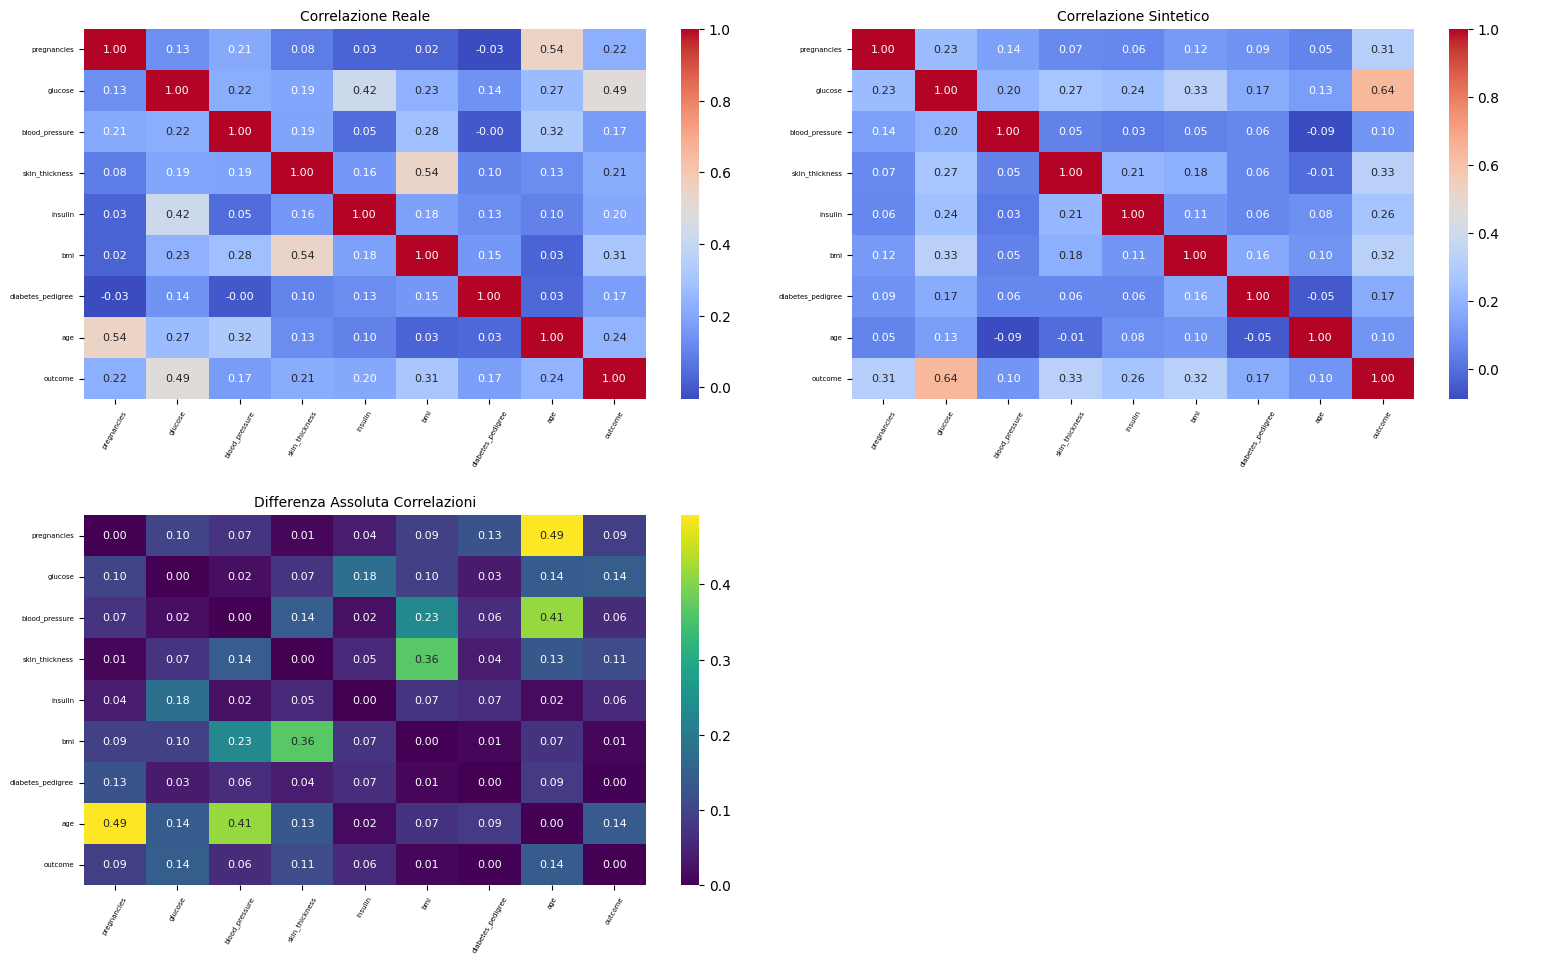

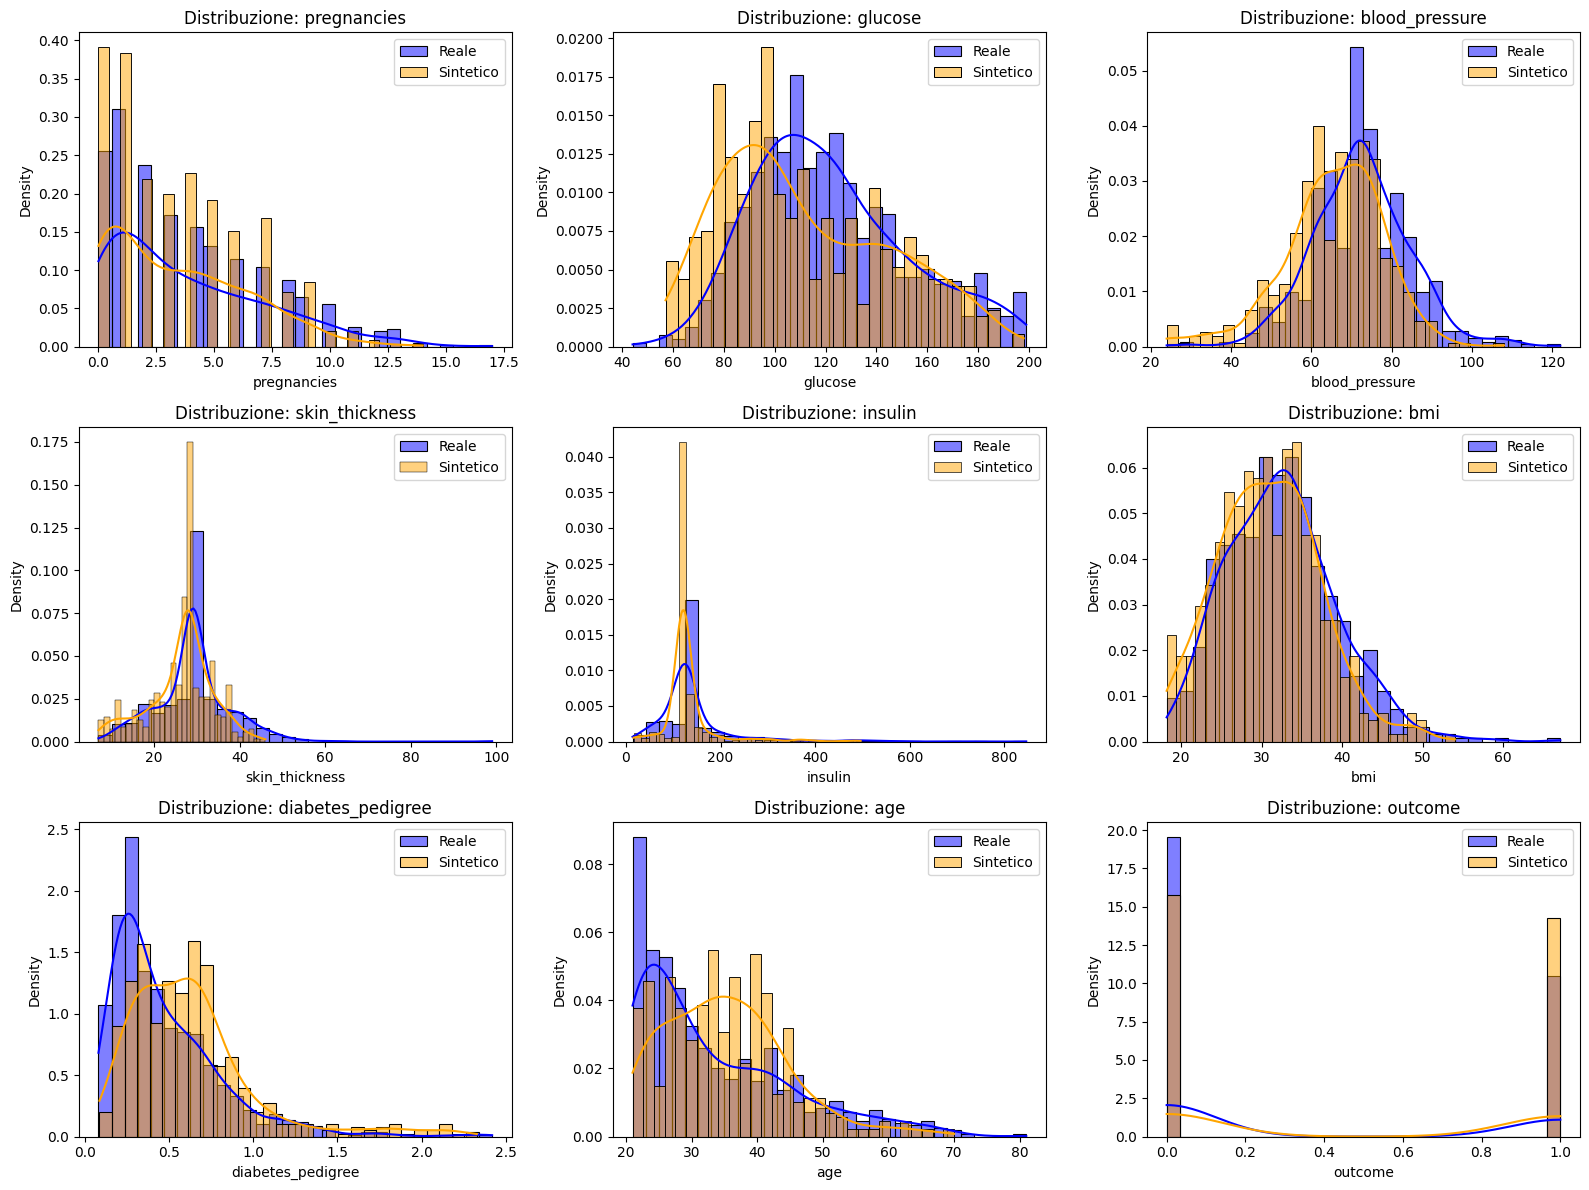


===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY MODERATA =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           5.2980       1.4529
glucose                          121.6562         117.6144      -4.0418
blood_pressure                    72.3867          66.9282      -5.4585
skin_thickness                    29.1081          32.0416       2.9336
insulin                          140.6719         273.9062     133.2343
bmi                               32.4552          40.7373       8.2821
diabetes_pedigree                  0.4719           1.0171       0.5452
age                               33.2409          42.9348       9.6939
outcome                            0.3490           0.5177       0.1687

Confronto MATRICE DI CORRELAZIONE:


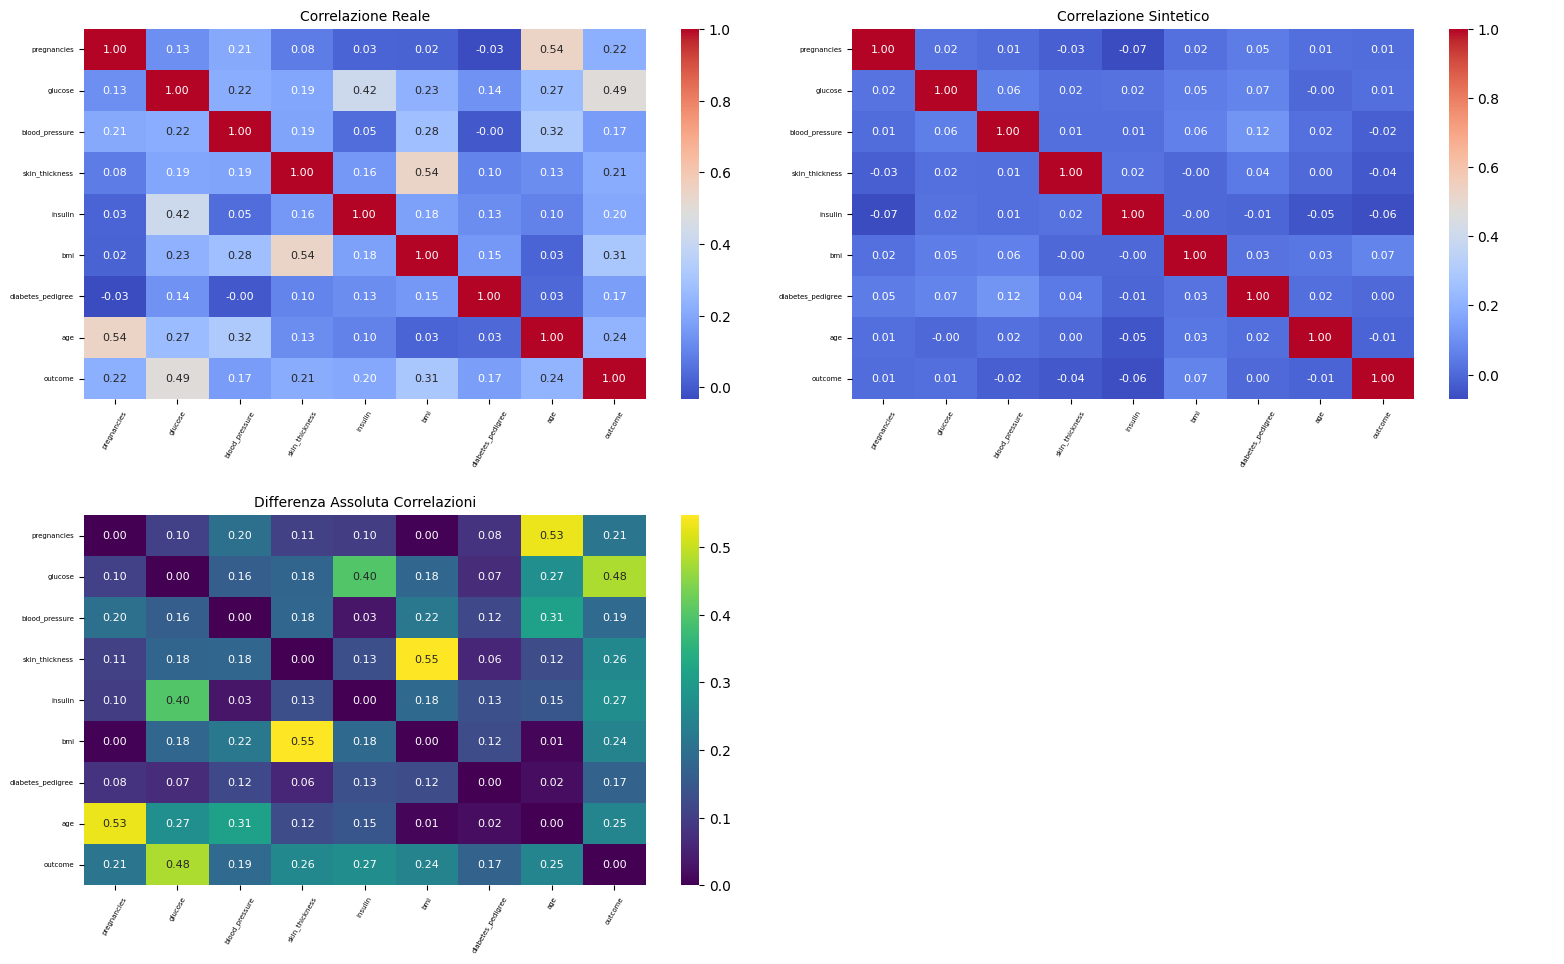

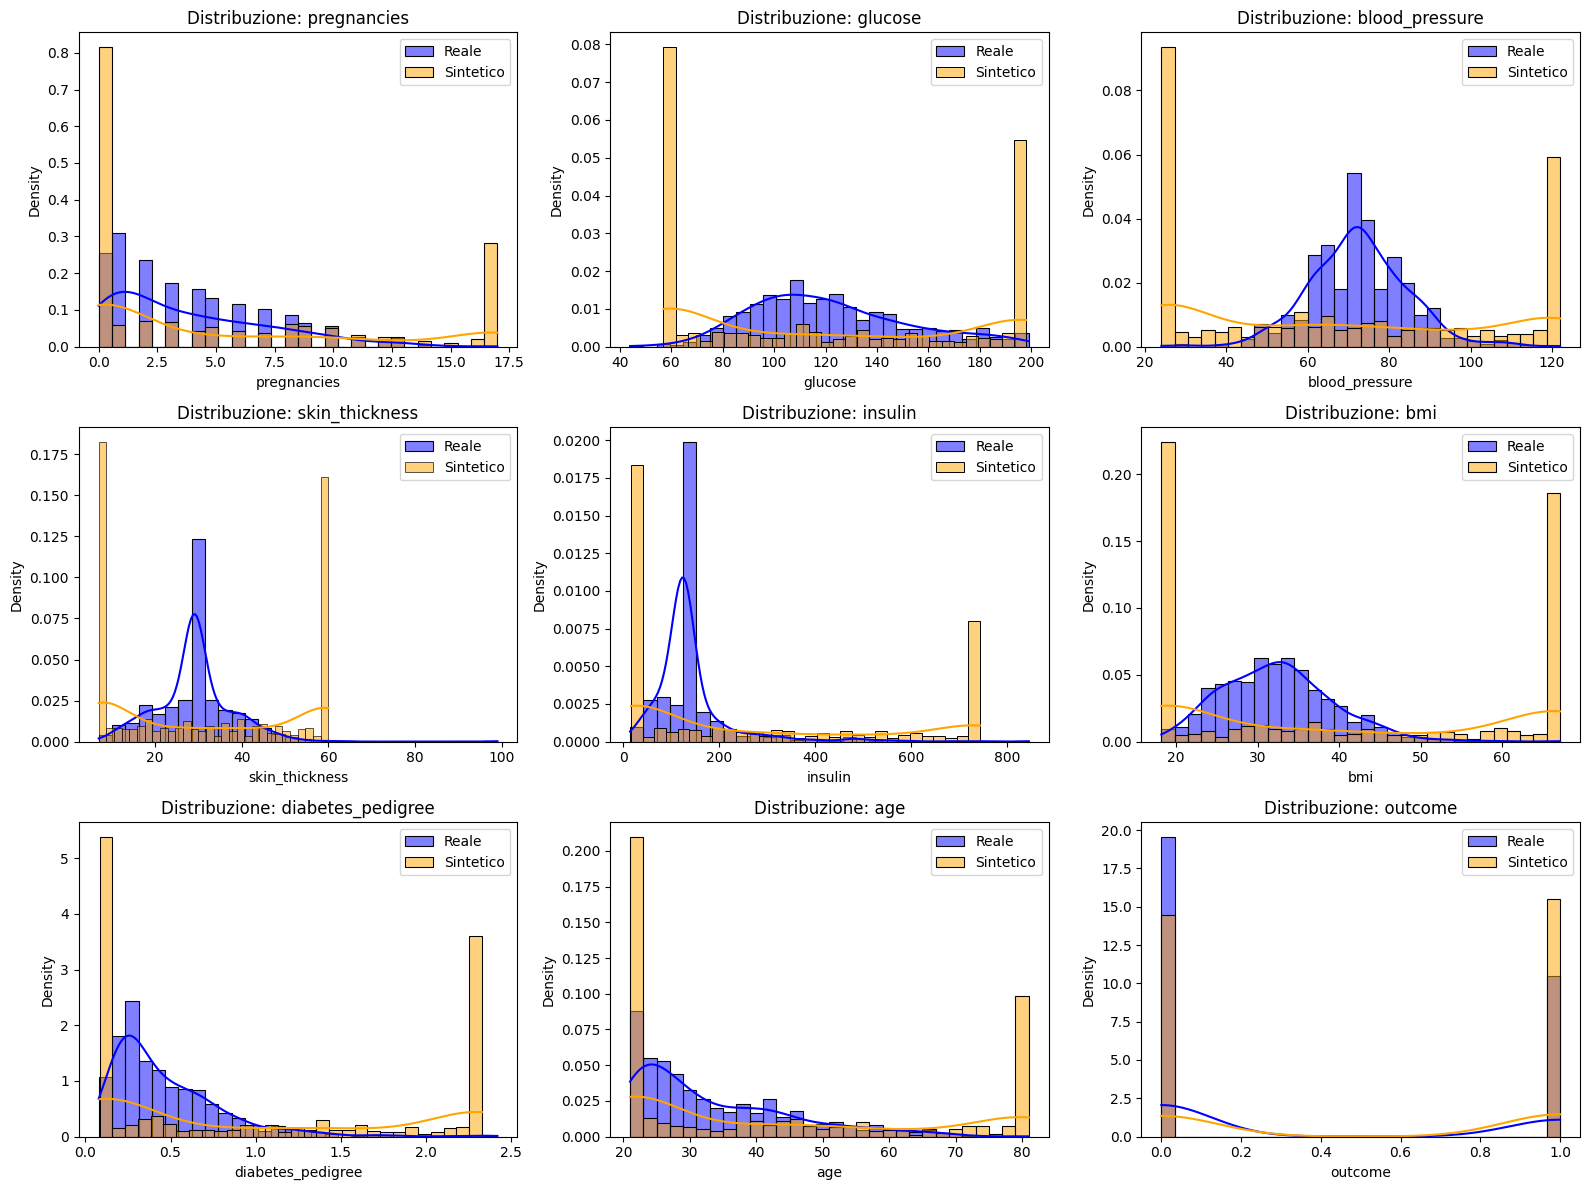


===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY STRONG =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           8.5400       4.6950
glucose                          121.6562         129.2943       7.6380
blood_pressure                    72.3867          73.5981       1.2114
skin_thickness                    29.1081          32.2911       3.1830
insulin                          140.6719         363.0691     222.3972
bmi                               32.4552          42.5810      10.1258
diabetes_pedigree                  0.4719           1.0744       0.6025
age                               33.2409          50.6052      17.3643
outcome                            0.3490           0.4749       0.1259

Confronto MATRICE DI CORRELAZIONE:


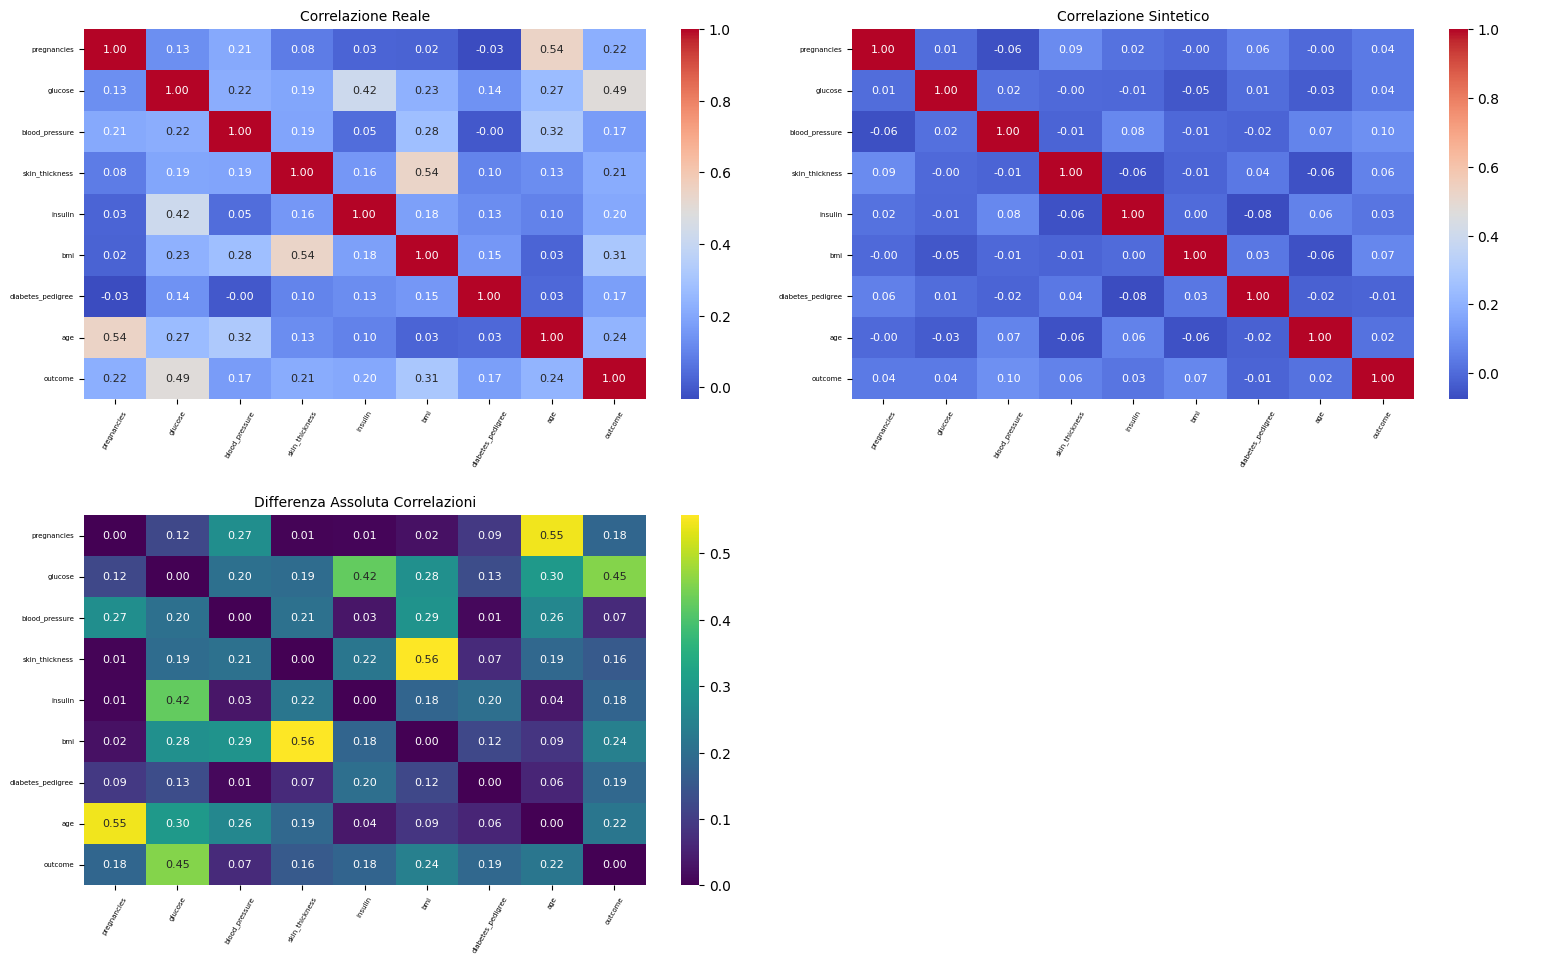

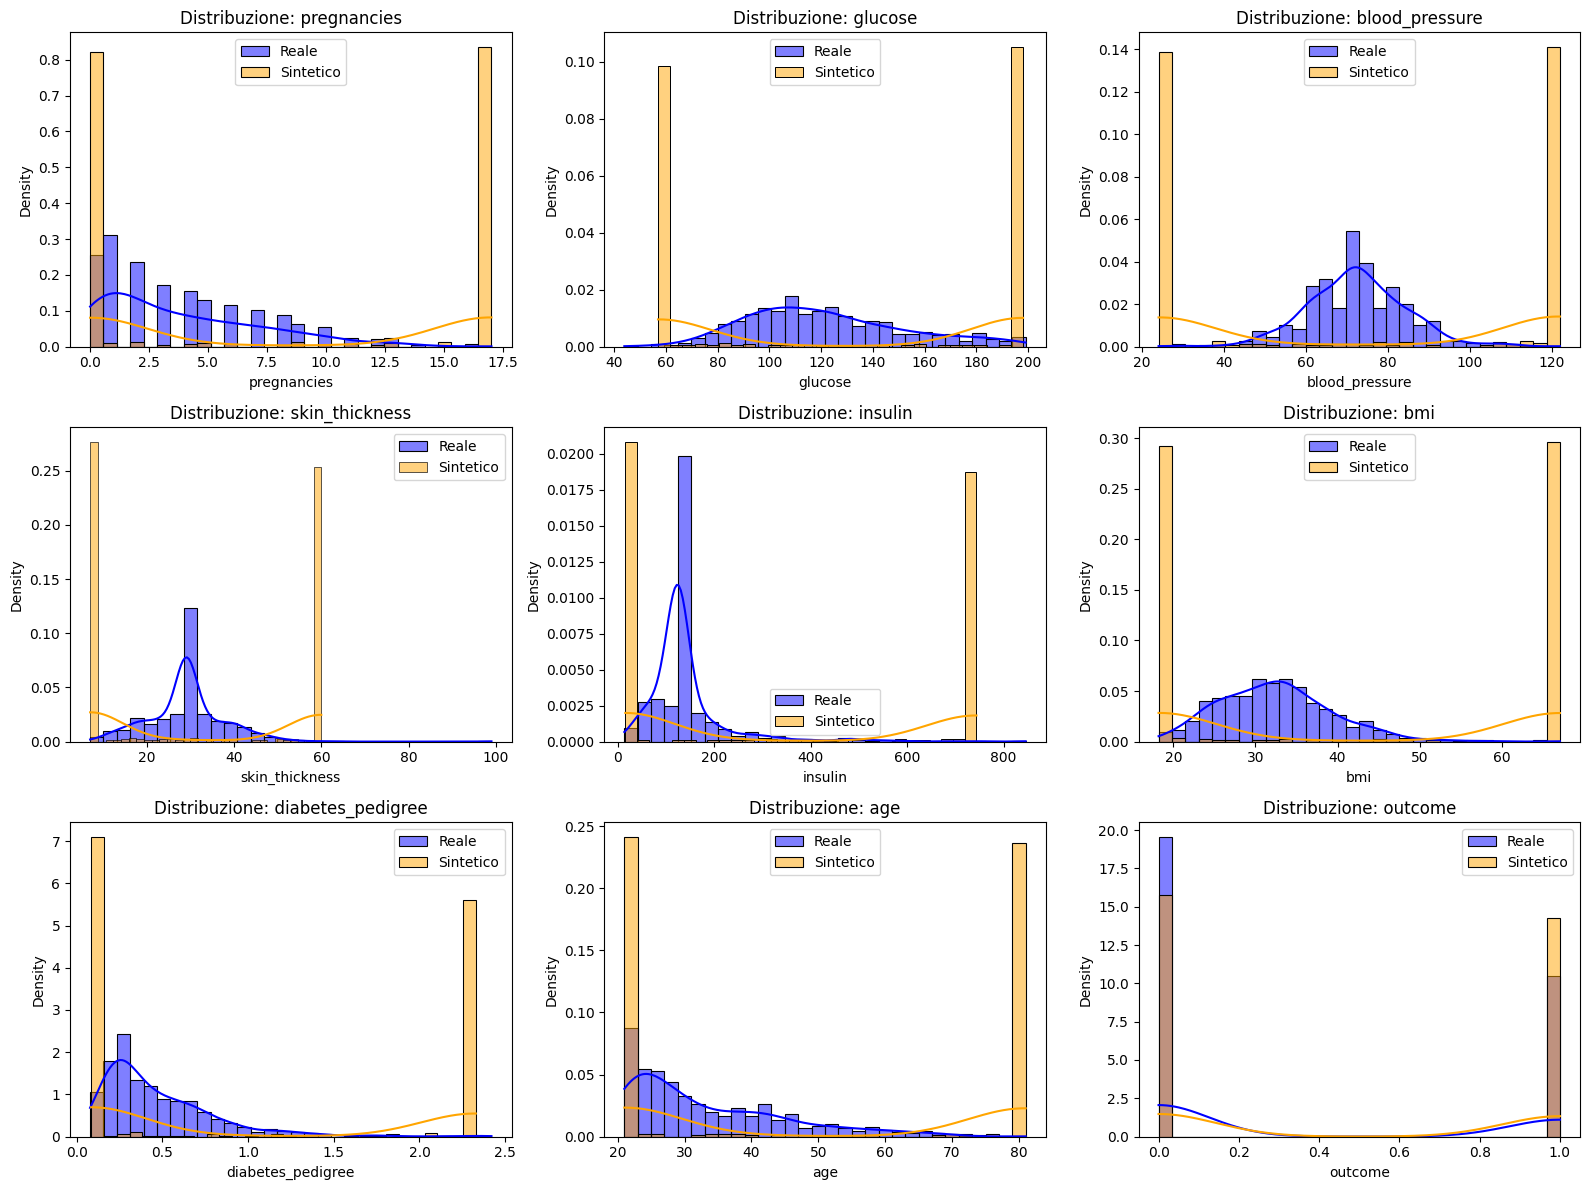

In [93]:
def somiglianza_statistica(real, synth, metadata, nome=""):
    print(f"\n===== ANALISI SOMIGLIANZA STATISTICA: {nome} =====")

    num_cols = [col for col in real.columns if pd.api.types.is_numeric_dtype(real[col])]

    print("\nConfronto delle medie tra reale e sintetico:")
    print("{:<28} {:>12} {:>16} {:>12}".format('Feature', 'Mean Real', 'Mean Synthetic', 'Diff'))
    for col in num_cols:
        mean_real = real[col].mean()
        mean_synth = synth[col].mean()
        diff = mean_synth - mean_real
        print("{:<28} {:>12.4f} {:>16.4f} {:>12.4f}".format(col, mean_real, mean_synth, diff))

    # 2. Confronto MATRICE DI CORRELAZIONE
    print("\nConfronto MATRICE DI CORRELAZIONE:")
    real_corr = real[num_cols].corr()
    synth_corr = synth[num_cols].corr()
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    # Prima riga:
    sns.heatmap(real_corr, ax=axes[0, 0], cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[0, 0].set_title('Correlazione Reale', fontsize=10)
    axes[0, 0].tick_params(axis='x', labelsize=5, rotation=60)
    axes[0, 0].tick_params(axis='y', labelsize=5)
    sns.heatmap(synth_corr, ax=axes[0, 1], cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[0, 1].set_title('Correlazione Sintetico', fontsize=10)
    axes[0, 1].tick_params(axis='x', labelsize=5, rotation=60)
    axes[0, 1].tick_params(axis='y', labelsize=5)
    # Seconda riga:
    axes[1, 1].axis('off')
    sns.heatmap(abs(real_corr - synth_corr), ax=axes[1, 0], cmap='viridis', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[1, 0].set_title('Differenza Assoluta Correlazioni', fontsize=10)
    axes[1, 0].tick_params(axis='x', labelsize=5, rotation=60)
    axes[1, 0].tick_params(axis='y', labelsize=5)
    plt.tight_layout(pad=2)
    plt.show()

    # 3. Confronto DISTRIBUZIONI
    num_per_row = 3
    num_cols_total = len(num_cols)
    num_rows = int(np.ceil(num_cols_total / num_per_row))
    fig_width = 16
    fig_height = 4 * num_rows
    fig, axes = plt.subplots(num_rows, num_per_row, figsize=(fig_width, fig_height))
    axes = axes.flatten()
    for ax, col in zip(axes, num_cols):
        sns.histplot(real[col], color='blue', label='Reale', kde=True, stat="density", bins=30, alpha=0.5, ax=ax)
        sns.histplot(synth[col], color='orange', label='Sintetico', kde=True, stat="density", bins=30, alpha=0.5, ax=ax)
        ax.set_title(f'Distribuzione: {col}')
        ax.set_ylabel('Density')
        ax.set_xlabel(col)
        ax.legend()
    for ax in axes[len(num_cols):]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

datasets_sintetici = [
    ("NO PRIVACY", synthetic_noprivacy, metadata_noprivacy),
    ("PRIVACY MODERATA", synthetic_mod, metadata_mod),
    ("PRIVACY STRONG", synthetic_strong, metadata_strong)
]

for nome, synth_df, meta in datasets_sintetici:
    somiglianza_statistica(df, synth_df, meta, nome)


**VALUTARE UTILITA' PER LA RICERCA**: addestrare modelli di predizione delle malattie su dati sintetici e valutarli su un set reale di holdout

TRINING DEI MODELLI CON I DIVERSI DATASET SINTETICI GENERATI (NO PRIVACY, MODERATA, STRONG)

In [94]:
def train_and_save_xgboost(synthetic_df, privacy_label, model_params=None, target_col="outcome"):
    """
    Allena un modello XGBoost su un dataset sintetico e lo salva su disco.

    Args:
        synthetic_df: pd.DataFrame, dati sintetici da usare (features + target).
        privacy_label: str, etichetta privacy usata nel nome file ("noprivacy", "mod", "strong").
        model_params: dict, parametri opzionali per XGBClassifier.
        target_col: str, nome della colonna target (default: "outcome").

    Returns:
        Il modello allenato.
    """
    if model_params is None:
        # Parametri di default robusti
        model_params = dict(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            eval_metric="logloss",
            random_state=42
        )
    X = synthetic_df.drop(columns=[target_col])
    y = synthetic_df[target_col]
    model = XGBClassifier(**model_params)
    model.fit(X, y)
    filename = f'xgboost_model_{privacy_label}.pkl'
    joblib.dump(model, filename)
    print(f"Modello XGBoost addestrato e salvato: {filename}")
    return model

# Allena 3 modelli con diversi i dataset sintetici di input
print("Training modello con dataset NO PRIVACY...")
model_noprivacy = train_and_save_xgboost(synthetic_noprivacy, "noprivacy")
print("Training modello con dataset PRIVACY MODERATA...")
model_modprivacy = train_and_save_xgboost(synthetic_mod, "modprivacy")
print("Training modello con dataset PRIVACY STRONG...")
model_strongprivacy = train_and_save_xgboost(synthetic_strong, "strongprivacy")

Training modello con dataset NO PRIVACY...
Modello XGBoost addestrato e salvato: xgboost_model_noprivacy.pkl
Training modello con dataset PRIVACY MODERATA...
Modello XGBoost addestrato e salvato: xgboost_model_modprivacy.pkl
Training modello con dataset PRIVACY STRONG...
Modello XGBoost addestrato e salvato: xgboost_model_strongprivacy.pkl


TEST DEI MODELLI SU DATI REALI HOLDOUT

In [95]:
def test_xgboost_model(model, X_real, y_real, privacy_label):
    y_pred = model.predict(X_real)
    y_prob = model.predict_proba(X_real)[:, 1]
    print(f"\nPerformance del modello allenato su dati {privacy_label.upper()} e testato su Dataset Reale di Holdout")
    print("Accuracy:", accuracy_score(y_real, y_pred))
    print("ROC-AUC:", roc_auc_score(y_real, y_prob))
    print("\nClassification Report:")
    print(classification_report(y_real, y_pred))

# Separa feature e target nel dataset holdout (lo fai una sola volta)
X_real = holdout_df.drop(columns=["outcome"])
y_real = holdout_df["outcome"]

# Usa la funzione per tutti i modelli
print("Testing modello (allenato con dataset NO PRIVACY) su dati holdout...")
test_xgboost_model(model_noprivacy, X_real, y_real, "no privacy")
print("Testing modello (allenato con dataset PRIVACY MODERATA) su dati holdout...")
test_xgboost_model(model_modprivacy, X_real, y_real, "moderate privacy (ε=1.0)")
print("Testing modello (allenato con dataset PRIVACY STRONG) su dati holdout...")
test_xgboost_model(model_strongprivacy, X_real, y_real, "strong privacy (ε=0.1)")


Testing modello (allenato con dataset NO PRIVACY) su dati holdout...

Performance del modello allenato su dati NO PRIVACY e testato su Dataset Reale di Holdout
Accuracy: 0.70995670995671
ROC-AUC: 0.820164609053498

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.65      0.74       150
           1       0.56      0.83      0.67        81

    accuracy                           0.71       231
   macro avg       0.72      0.74      0.70       231
weighted avg       0.76      0.71      0.72       231

Testing modello (allenato con dataset PRIVACY MODERATA) su dati holdout...

Performance del modello allenato su dati MODERATE PRIVACY (Ε=1.0) e testato su Dataset Reale di Holdout
Accuracy: 0.3939393939393939
ROC-AUC: 0.5044444444444444

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.16      0.26       150
           1       0.35      0.83      0.49        81

    accura